In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np
import geopandas as gpd
from glob import glob

In [3]:
sys.path.insert(1,'../../scripts/03_plant_optimization/')

In [4]:
import plant_optimization as pop
from plant_optimization.notebook_tools import *

In [5]:
europe_grid = gpd.read_file('../../results_samples/Europe_Evaluation_Grid.shp')
europe_grid.rename(columns={'grid_lat':'lat','grid_lon':'lon'},inplace=True)
europe_grid['sea_node'] = europe_grid.sea_node.astype(bool)
europe_borders = gpd.read_file('../../results_samples/Europe_WGS84.shp')

In [6]:
results_path = os.path.join('../../results/02_plant_optimization') # Points to the location of the results csv files

In [7]:
def plot_results(data,countries,metrics,figsize=(25,20),ncols=None,fontsize=None,cmap=None,vmax_dict={},missing_kwds=None,legend_kwds={}):
    if ncols == None:
        ncols = int(np.ceil(np.sqrt(len(metrics))))
    nrows = int(np.ceil(len(metrics)/ncols))
    fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize)
    axes = np.reshape(axes,(1,nrows*ncols))[0]

    if fontsize == None:
        fontsize = figsize[0]*2
    df = data.loc[data.country.isin(countries)].copy()
    borders = europe_borders.loc[europe_borders.country.isin(countries)].copy()
    cmap = 'viridis_r'
    for i,(metric,description) in enumerate(metrics.items()):
        vmax = vmax_dict[metric] if metric in vmax_dict.keys() else None
        if metric not in ['turbine_type','specific_capacity_class']:
            l_kwds = legend_kwds.copy()
            l_kwds.setdefault('orientation','horizontal')
            l_kwds['ax'] = axes[i]
            l_kwds.pop('bbox_to_anchor',None)
            l_kwds.pop('fontsize',None)
        else:
            l_kwds = legend_kwds.copy()
            l_kwds.pop('orientation',None)
            l_kwds.setdefault('loc','upper center')
            l_kwds.setdefault('ncol',min(3,df[metric].nunique()))
            l_kwds.setdefault('fontsize',fontsize*.75)
            
            if df[metric].nunique()>10:
                cmap = 'tab20'
        df.plot(column=metric,legend=True,cmap=cmap,vmax=vmax,missing_kwds=missing_kwds,legend_kwds=l_kwds,ax=axes[i])
        borders.boundary.plot(color='k',ax=axes[i])
        cb_ax = axes[i].figure.axes[-1]
        cb_ax.tick_params(labelsize=fontsize)
        axes[i].axis('off')
        axes[i].set_title(description,fontsize=fontsize)
#     plt.tight_layout()

In [8]:
def plot_country(country,metrics,**plot_results_kwds):
    results = pd.DataFrame()
    for file_glob in glob(f'{results_path}/{country}*.csv'): 
        results = results.append(pd.read_csv(file_glob,index_col=0))
    results['country'] = country
    results_gdf = gpd.GeoDataFrame(results.merge(europe_grid,on=['lat','lon','country'],how='left'))
    results_gdf = results_gdf.loc[~results_gdf.sea_node]
    plot_results(data=results_gdf,metrics=metrics,countries=[country],**plot_results_kwds)

# Onshore

In [61]:
# countries = ['Switzerland','Austria','Germany','France','Italy']
# countries = ['Belgium']
countries = europe_grid.country.unique()
results = pd.DataFrame()
for country in countries:
    df = pd.DataFrame()
    for file_glob in glob(f'{results_path}/{country}*.csv'): 
        df = df.append(pd.read_csv(file_glob,index_col=0))#.set_index(['lat','lon'])
    df['country'] = country
    results = results.append(df)
results_gdf = gpd.GeoDataFrame(results.merge(europe_grid,on=['lat','lon','country'],how='left'))
results_gdf = results_gdf.loc[~results_gdf.sea_node]

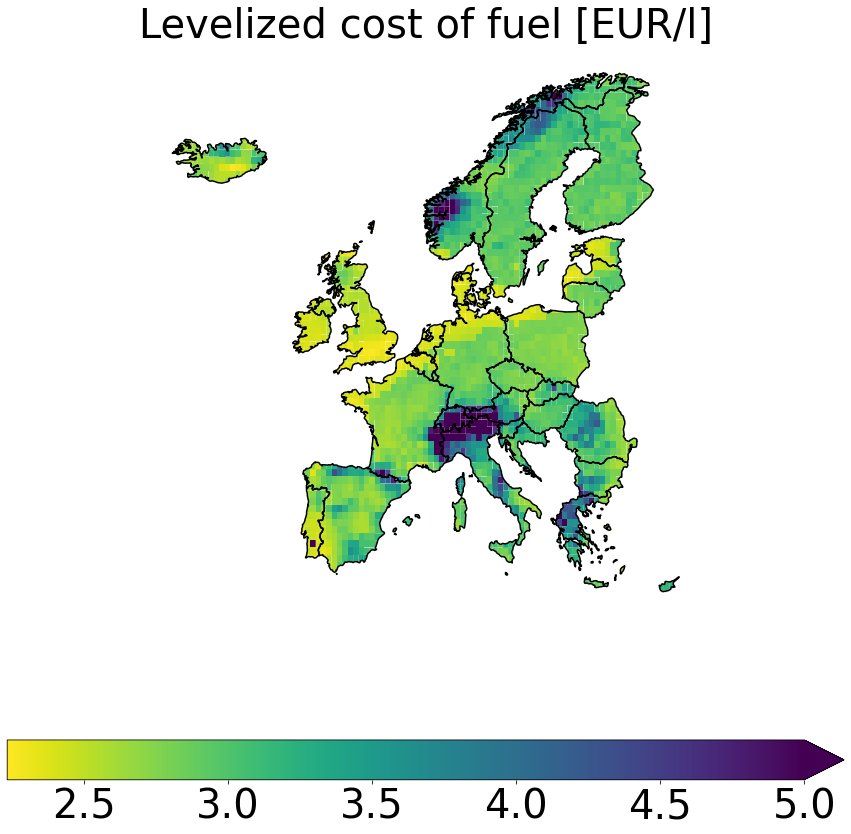

In [62]:
data = results_gdf.copy()
# countries = ['Switzerland','Austria','Germany']
metrics = {'LCOF_liter':'Levelized cost of fuel [EUR/l]'}#,
#            'wind_capacity_MW':'Installed wind power capacity [MW]',
#            'PV_capacity_MW':'Installed PV power capacity [MW]',
#            'curtailed_el_MWh':'Curtailed electricity production [MWh]'}
vmax_dict = {'LCOF_liter':5}#,'wind_capacity_MW':25,'PV_capacity_MW':50,'curtailed_el_MWh':5000}
legend_kwds = {'extend':'max'}
fontsize = 40
plot_results(data=data,countries=countries,metrics=metrics,vmax_dict=vmax_dict,legend_kwds=legend_kwds,figsize=(15,15),fontsize=fontsize)
# plt.savefig('../../gfx/LCOF_onshore.png',dpi=400)

In [63]:
data.columns

Index(['lat', 'lon', 'shore_designation', 'turbine_type', 'rotor_diameter',
       'rated_turbine_power', 'wind_turbines', 'wind_capacity_MW',
       'PV_capacity_MW', 'electrolyzer_capacity_MW', 'CO2_capture_tonph',
       'heatpump_capacity_MW', 'battery_capacity_MWh', 'H2stor_capacity_MWh',
       'CO2stor_capacity_ton', 'H2tL_capacity_MW', 'curtailed_el_MWh',
       'wind_production_MWh', 'PV_production_MWh', 'NPV_EUR', 'CAPEX_EUR',
       'LCOF_MWh', 'LCOF_liter', 'runtime', 'country', 'in_country',
       'pt_in_sea', 'sea_node', 'cent_lat', 'cent_lon', 'merra_lat',
       'merra_lon', 'pv_lat', 'pv_lon', 'geometry'],
      dtype='object')

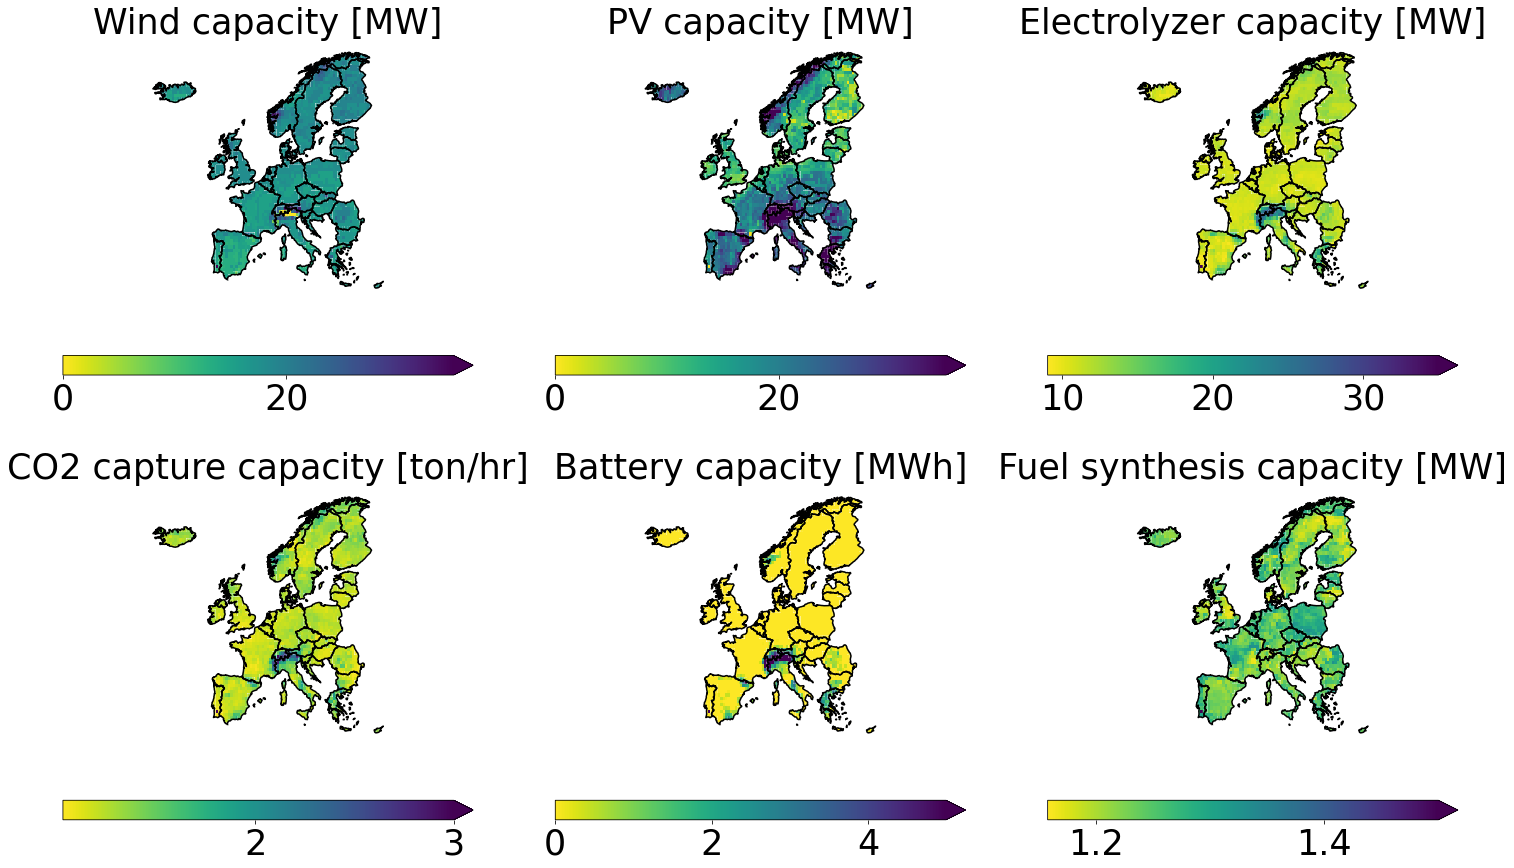

In [64]:
data = results_gdf.copy()
metrics = {'wind_capacity_MW':'Wind capacity [MW]',
           'PV_capacity_MW':'PV capacity [MW]',
           'electrolyzer_capacity_MW':'Electrolyzer capacity [MW]',
           'CO2_capture_tonph':'CO2 capture capacity [ton/hr]',
           'battery_capacity_MWh':'Battery capacity [MWh]',
           'H2tL_capacity_MW':'Fuel synthesis capacity [MW]'}
vmax_dict = {'wind_capacity_MW':35,
             'PV_capacity_MW':35,
             'electrolyzer_capacity_MW':35,
             'CO2_capture_tonph':3,
             'battery_capacity_MWh':5,
             'H2tL_capacity_MW':1.5}
legend_kwds = {'extend':'max'}
fontsize = 35
plot_results(data=data,countries=countries,metrics=metrics,vmax_dict=vmax_dict,legend_kwds=legend_kwds,figsize=(25,15),fontsize=fontsize)

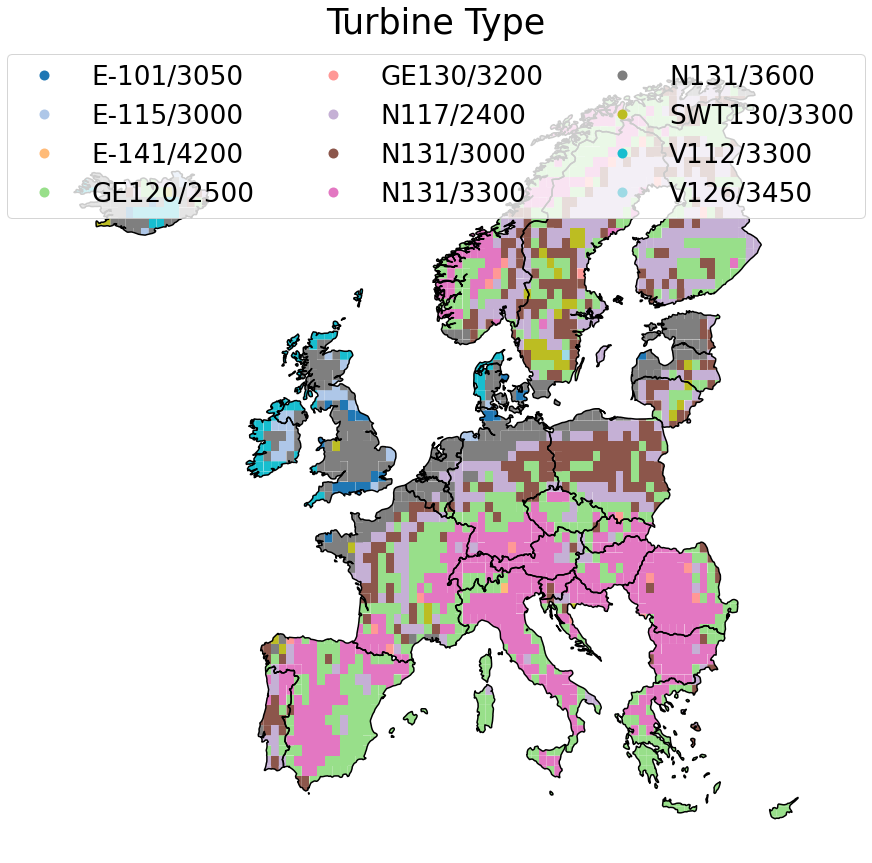

In [65]:
data = results_gdf.copy()
metrics = {'turbine_type':'Turbine Type'}
vmax_dict = None
legend_kwds = None
fontsize = 35
plot_results(data=data,countries=countries,metrics=metrics,figsize=(15,15),fontsize=fontsize)

# Offshore

In [66]:
# countries = ['Switzerland','Austria','Germany','France','Italy']
# countries = ['Belgium']
countries = europe_grid.country.unique()
results = pd.DataFrame()
for country in countries:
    df = pd.DataFrame()
    for file_glob in glob(f'{results_path}/offshore/{country}*.csv'): 
        df = df.append(pd.read_csv(file_glob,index_col=0))#.set_index(['lat','lon'])
    df['country'] = country
    results = results.append(df)
results_gdf = gpd.GeoDataFrame(results.merge(europe_grid,on=['lat','lon','country'],how='left'))
results_gdf = results_gdf.loc[results_gdf.sea_node]

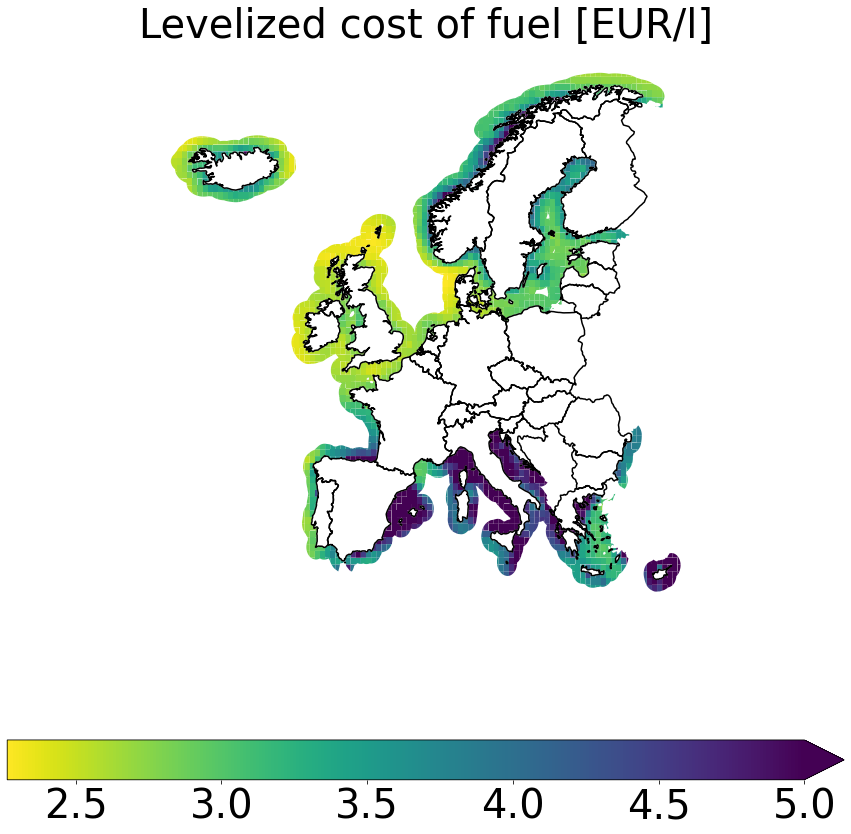

In [67]:
data = results_gdf.copy()
# countries = ['Switzerland','Austria','Germany']
metrics = {'LCOF_liter':'Levelized cost of fuel [EUR/l]'}#,
#            'wind_capacity_MW':'Installed wind power capacity [MW]',
#            'PV_capacity_MW':'Installed PV power capacity [MW]',
#            'curtailed_el_MWh':'Curtailed electricity production [MWh]'}
vmax_dict = {'LCOF_liter':5}#,'wind_capacity_MW':25,'PV_capacity_MW':50,'curtailed_el_MWh':5000}
legend_kwds = {'extend':'max'}
fontsize = 40
plot_results(data=data,countries=countries,metrics=metrics,vmax_dict=vmax_dict,legend_kwds=legend_kwds,figsize=(15,15),fontsize=fontsize)
# plt.savefig('../../gfx/LCOF_onshore.png',dpi=400)

# Combined

In [68]:
# countries = ['Switzerland','Austria','Germany','France','Italy']
countries = europe_grid.country.unique()
# countries = ['France']
results = pd.DataFrame()
for country in countries:
    df = pd.DataFrame()
    for file_glob in glob(f'{results_path}/{country}*.csv'): 
        df = df.append(pd.read_csv(file_glob,index_col=0))#.set_index(['lat','lon'])
    df['sea_node'] = False
    df_sea = pd.DataFrame()
    for file_glob in glob(f'{results_path}/offshore/{country}*.csv'): 
        df_sea = df_sea.append(pd.read_csv(file_glob,index_col=0))#.set_index(['lat','lon'])
    df_sea['sea_node'] = True
    df = df.append(df_sea)
    df['country'] = country
    results = results.append(df)
results_gdf = gpd.GeoDataFrame(results.merge(europe_grid,on=['lat','lon','country','sea_node'],how='left'))

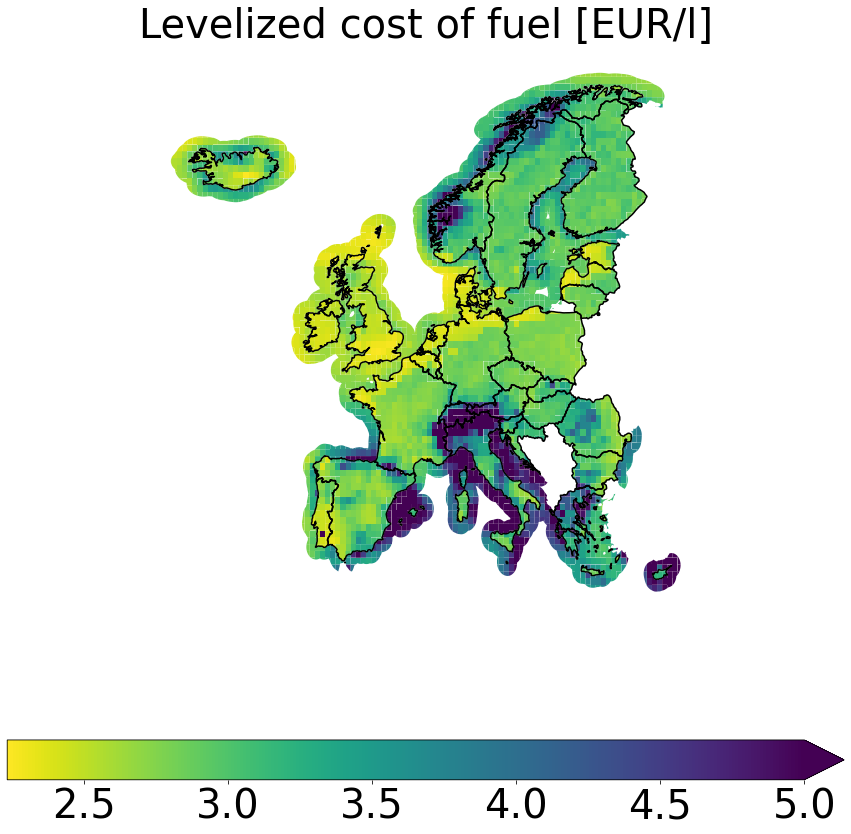

In [69]:
data = results_gdf.copy()
# countries = ['Switzerland','Austria','Germany']
metrics = {'LCOF_liter':'Levelized cost of fuel [EUR/l]'}#,
#            'wind_capacity_MW':'Installed wind power capacity [MW]',
#            'PV_capacity_MW':'Installed PV power capacity [MW]',
#            'curtailed_el_MWh':'Curtailed electricity production [MWh]'}
vmax_dict = {'LCOF_liter':5}#,'wind_capacity_MW':25,'PV_capacity_MW':50,'curtailed_el_MWh':5000}
legend_kwds = {'extend':'max'}
fontsize = 40
plot_results(data=data,countries=countries,metrics=metrics,vmax_dict=vmax_dict,legend_kwds=legend_kwds,figsize=(15,15),fontsize=fontsize)
# plt.savefig('../../gfx/LCOF_combined.png',dpi=400)

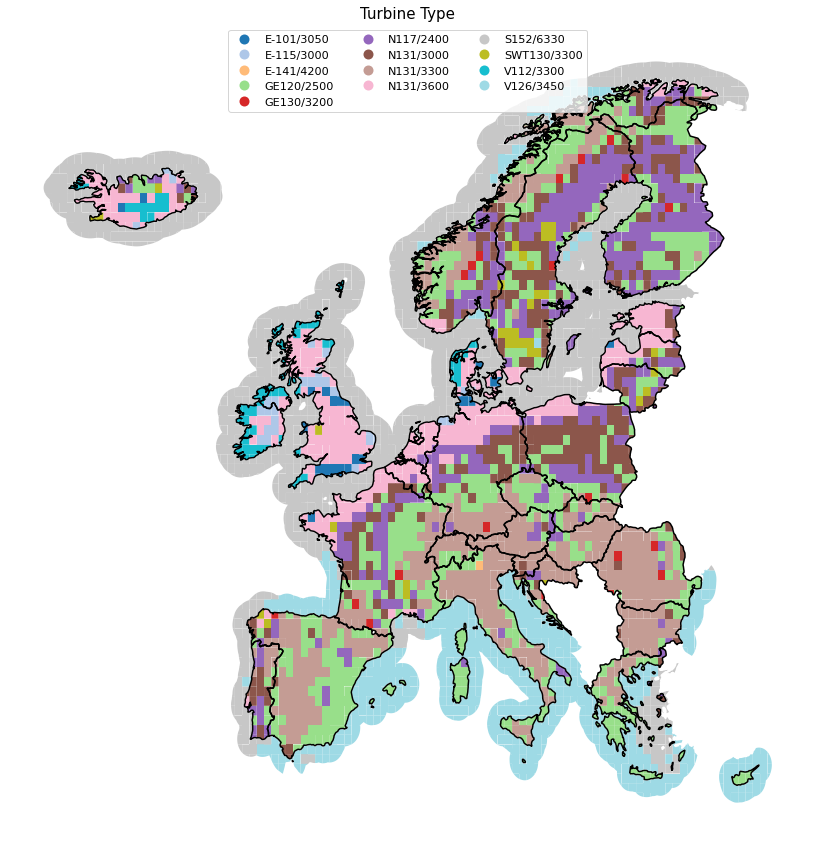

In [73]:
data = results_gdf.copy()
metrics = {'turbine_type':'Turbine Type'}
vmax_dict = None
legend_kwds = None
fontsize = 15
plot_results(data=data,countries=countries,metrics=metrics,figsize=(15,15),fontsize=fontsize)

,lat,lon,shore_designation,turbine_type,rotor_diameter,rated_turbine_power,wind_turbines,wind_capacity_MW,PV_capacity_MW,electrolyzer_capacity_MW,...,country,in_country,pt_in_sea,cent_lat,cent_lon,merra_lat,merra_lon,pv_lat,pv_lon,geometry
3764,38.0,-8.750,onshore,GE120/2500,120.0,2500.0,6.0,15.00,15.790399,9.885332,...,Portugal,1,0,37.997997,-8.620176,38.0,-8.750,37.997997,-8.620176,"POLYGON ((-8.77702 38.25000, -8.43750 38.25000..."
3775,38.0,-8.125,onshore,N117/2400,117.0,2400.0,159.0,381.60,0.000000,100.000000,...,Portugal,1,0,38.000000,-8.125000,38.0,-8.125,38.000000,-8.125000,"POLYGON ((-8.43750 38.25000, -7.81250 38.25000..."
3786,38.0,-7.500,onshore,GE120/2500,120.0,2500.0,5.0,12.50,19.969061,9.803053,...,Portugal,1,0,38.014705,-7.523129,38.0,-7.500,38.014705,-7.523129,"POLYGON ((-7.81250 38.25000, -7.18750 38.25000..."
3795,38.0,-6.875,onshore,GE120/2500,120.0,2500.0,5.0,12.50,20.274677,10.007467,...,Portugal,0,0,38.119761,-7.082506,38.0,-6.875,38.119761,-7.082506,"POLYGON ((-7.18750 38.25000, -7.14751 38.25000..."
3807,38.0,-10.625,offshore,S152/6330,152.0,6330.0,4.0,25.32,0.000000,10.851960,...,Portugal,0,1,38.195088,-10.364872,38.0,-10.625,NaN,NaN,"POLYGON ((-10.46484 38.25000, -10.31250 38.250..."
3815,38.0,-10.000,offshore,S152/6330,152.0,6330.0,4.0,25.32,0.000000,11.326870,...,Portugal,0,1,38.033032,-9.951304,38.0,-10.000,NaN,NaN,"POLYGON ((-10.31250 38.25000, -9.68750 38.2500..."
3829,38.0,-9.375,offshore,S152/6330,152.0,6330.0,4.0,25.32,0.000000,12.404397,...,Portugal,0,1,38.000000,-9.375000,38.0,-9.375,NaN,NaN,"POLYGON ((-9.68750 38.25000, -9.06250 38.25000..."
3842,38.0,-8.750,offshore,S152/6330,152.0,6330.0,4.0,25.32,0.000000,12.404397,...,Portugal,1,0,38.003568,-8.960676,38.0,-9.375,NaN,NaN,"POLYGON ((-9.06250 38.25000, -8.83416 38.25000..."


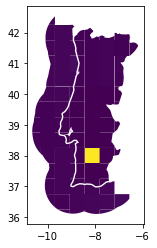

In [80]:
ptg = data.loc[data.country=='Portugal']
ptg.plot(column='LCOF_liter')
ptg.loc[ptg.lat==38]

In [85]:
data.loc[data.runtime>2000].iloc[:,10:30]

,CO2_capture_tonph,heatpump_capacity_MW,battery_capacity_MWh,H2stor_capacity_MWh,CO2stor_capacity_ton,H2tL_capacity_MW,curtailed_el_MWh,wind_production_MWh,PV_production_MWh,NPV_EUR,CAPEX_EUR,LCOF_MWh,LCOF_liter,runtime,sea_node,country,in_country,pt_in_sea,cent_lat,cent_lon
406,1.205966,2.696619,0.0,408.511313,237.300734,1.220724,625.175444,103382.052802,0.0,8.789985e+07,4.655270e+07,235.694076,2.309802,3000.078008,True,Denmark,0,1,56.054598,6.534293
407,1.193029,2.662667,0.0,364.457825,272.834348,1.226902,4812.730212,105018.197152,0.0,8.618648e+07,4.537555e+07,231.099867,2.264779,3000.072089,True,Denmark,0,1,56.489904,6.532492
408,1.201745,2.684355,0.0,351.325646,347.002728,1.227292,789.316999,105193.302906,0.0,8.639258e+07,4.534649e+07,231.652513,2.270195,3000.089120,True,Denmark,0,1,56.777591,6.552458
544,1.258128,2.817588,0.0,695.510261,393.293102,1.256919,504.949378,115589.527948,0.0,1.110329e+08,6.260802e+07,297.722784,2.917683,2158.580437,True,Estonia,0,1,57.998321,23.126988
545,1.258128,2.817588,0.0,695.510261,393.293102,1.256919,504.949378,115589.527948,0.0,1.110329e+08,6.260802e+07,297.722784,2.917683,2135.790771,True,Estonia,1,0,58.322444,23.254867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5182,1.221746,2.732771,0.0,456.177490,271.254933,1.233378,3943.196335,103338.986736,0.0,9.026218e+07,4.812788e+07,242.028427,2.371879,3000.118039,True,United_Kingdom,0,1,60.699279,-1.413359
5249,1.205488,2.690875,0.0,452.296012,259.656742,1.238180,5233.381105,102695.170261,0.0,9.018210e+07,4.819409e+07,241.813694,2.369774,3000.135876,True,United_Kingdom,0,1,60.000000,-0.625000
5250,1.216946,2.723526,0.0,473.417198,284.388803,1.222810,6088.710880,102535.601008,0.0,9.147159e+07,4.899291e+07,245.271328,2.403659,3000.102563,True,United_Kingdom,0,1,60.482073,-0.603595
5267,1.254565,2.812535,0.0,480.463358,381.788203,1.242139,614.610760,100842.243524,0.0,9.219356e+07,4.916052e+07,247.207223,2.422631,3000.151987,True,United_Kingdom,0,1,60.000000,-0.000000


In [79]:
ptg.head()

,lat,lon,shore_designation,turbine_type,rotor_diameter,rated_turbine_power,wind_turbines,wind_capacity_MW,PV_capacity_MW,electrolyzer_capacity_MW,...,country,in_country,pt_in_sea,cent_lat,cent_lon,merra_lat,merra_lon,pv_lat,pv_lon,geometry
3759,38.5,-9.375,onshore,N117/2400,117.0,2400.0,6.0,14.4,17.753088,9.906955,...,Portugal,0,1,38.555915,-9.139496,38.5,-8.750,38.555915,-9.139496,"MULTIPOLYGON (((-9.06250 38.64884, -9.06250 38..."
3760,39.0,-9.375,onshore,N131/3600,131.0,3600.0,5.0,18.0,10.269976,10.104264,...,Portugal,1,0,38.986034,-9.244644,39.0,-9.375,38.986034,-9.244644,"POLYGON ((-9.33818 39.25000, -9.06250 39.25000..."
3761,39.5,-9.375,onshore,N131/3000,131.0,3000.0,5.0,15.0,14.853423,9.681971,...,Portugal,0,1,39.381448,-9.173539,39.5,-8.750,39.381448,-9.173539,"POLYGON ((-9.06250 39.68904, -9.06250 39.25000..."
3762,37.0,-8.750,onshore,N117/2400,117.0,2400.0,6.0,14.4,16.664599,9.895422,...,Portugal,0,1,37.157462,-8.702854,37.5,-8.750,37.157462,-8.702854,"POLYGON ((-8.86790 37.25000, -8.43750 37.25000..."
3763,37.5,-8.750,onshore,N117/2400,117.0,2400.0,6.0,14.4,16.751732,9.821541,...,Portugal,1,0,37.491309,-8.623154,37.5,-8.750,37.491309,-8.623154,"POLYGON ((-8.79903 37.75000, -8.43750 37.75000..."


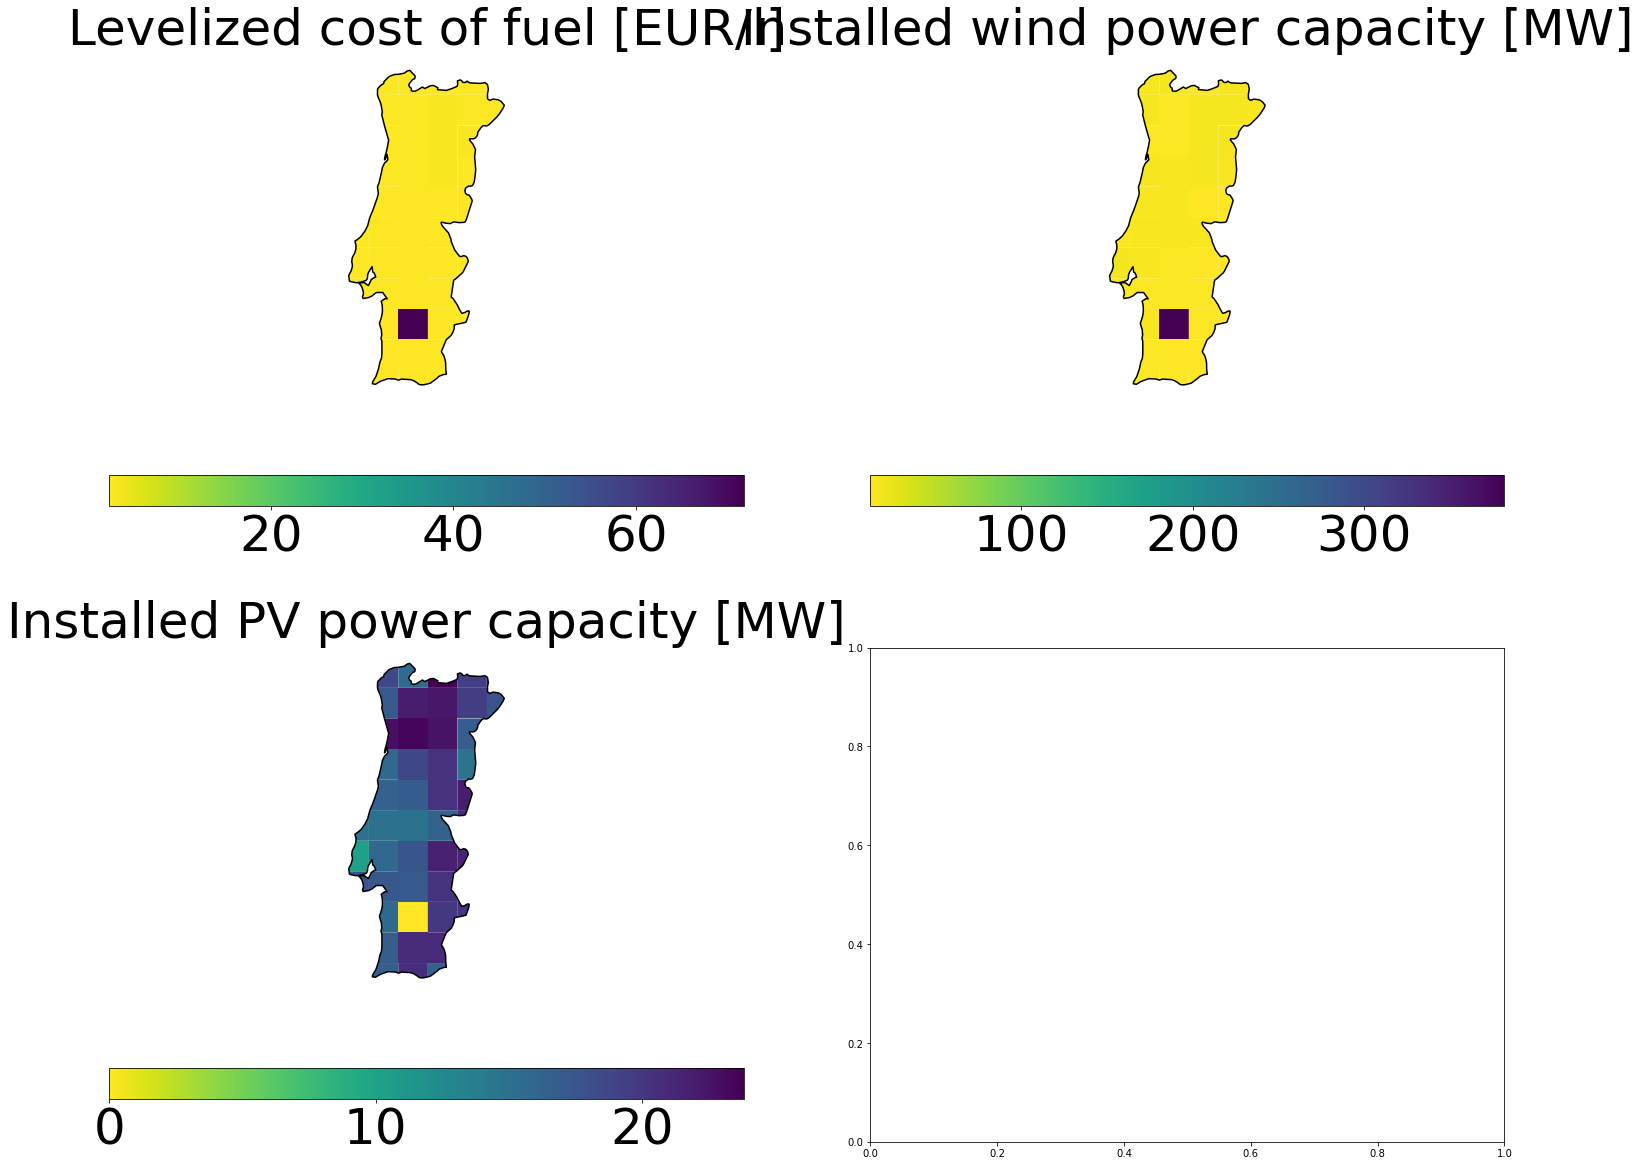

In [90]:
country = 'Portugal'
metrics = {'LCOF_liter':'Levelized cost of fuel [EUR/l]',
           'wind_capacity_MW':'Installed wind power capacity [MW]',
           'PV_capacity_MW':'Installed PV power capacity [MW]'}
plot_country(country,metrics)

In [43]:
results.sort_values('LCOF_liter',ascending=False)

,lat,lon,shore_designation,turbine_type,rotor_diameter,rated_turbine_power,wind_turbines,wind_capacity_MW,PV_capacity_MW,electrolyzer_capacity_MW,...,H2tL_capacity_MW,curtailed_el_MWh,wind_production_MWh,PV_production_MWh,NPV_EUR,CAPEX_EUR,LCOF_MWh,LCOF_liter,runtime,country
16,38.0,-8.125,onshore,N117/2400,117.0,2400.0,159.0,381.6,0.000000,100.000000,...,9.499280,347778.417847,1.752057e+06,0.000000,2.731293e+09,1.350265e+09,7323.670420,71.771970,2000.244433,Portugal
41,46.0,9.375,onshore,GE120/2500,120.0,2500.0,-0.0,-0.0,180.568646,27.480314,...,1.239924,37886.318077,0.000000e+00,155594.180159,4.349160e+08,2.987686e+08,1166.181052,11.428574,627.619738,Italy
24,46.0,10.000,onshore,GE120/2500,120.0,2500.0,-0.0,-0.0,179.891019,24.207199,...,1.247425,77280.520944,0.000000e+00,176162.070737,4.204389e+08,2.889247e+08,1127.362154,11.048149,468.194117,Switzerland
20,46.0,9.375,onshore,GE120/2500,120.0,2500.0,-0.0,-0.0,165.125642,29.058120,...,1.238264,51874.391944,0.000000e+00,144213.225911,3.960146e+08,2.670349e+08,1061.871077,10.406337,696.679099,Switzerland
25,46.5,10.000,onshore,GE120/2500,120.0,2500.0,3.0,7.5,151.476641,31.465085,...,1.228963,46.955473,2.770002e+03,135584.448156,3.953817e+08,2.621837e+08,1060.173852,10.389704,797.574508,Switzerland
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46,60.5,-1.250,onshore,V112/3300,112.0,3300.0,5.0,16.5,2.668293,11.389930,...,1.249240,3697.591177,9.538784e+04,3123.422894,8.539892e+07,4.462039e+07,228.988107,2.244083,1719.072327,United_Kingdom
16,59.0,-2.500,onshore,V112/3300,112.0,3300.0,5.0,16.5,4.550145,10.787425,...,1.241445,7123.158588,9.509802e+04,4105.736903,8.508675e+07,4.357285e+07,228.151057,2.235880,683.431921,United_Kingdom
0,59.0,-3.125,onshore,V112/3300,112.0,3300.0,5.0,16.5,4.550145,10.787425,...,1.241445,7123.158588,9.509802e+04,4105.736903,8.508675e+07,4.357285e+07,228.151057,2.235880,689.855671,United_Kingdom
17,59.5,-2.500,onshore,V112/3300,112.0,3300.0,5.0,16.5,4.653505,10.772381,...,1.241832,5732.124585,9.509802e+04,4234.289113,8.501766e+07,4.350299e+07,227.965795,2.234065,684.917258,United_Kingdom


# Max's Output

In [52]:
countries = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech_Republic', 'Denmark', 
            'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 
            'Italy', 'Latvia', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands',
            'Norway', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 
            'Switzerland', 'United_Kingdom']
results = pd.DataFrame()
for country in countries:
    df = pd.DataFrame()
    for file_glob in glob(f'{results_path}/{country}*.csv'): 
        df = df.append(pd.read_csv(file_glob,index_col=0))#.set_index(['lat','lon'])
    df['country'] = country
    results = results.append(df)
    
row = results.loc[(results.lat==40)&(results.lon==-6.25)].copy() #
row.lon = -6.875
results = results.append(row).reset_index(drop=True)
    
results_gdf = gpd.GeoDataFrame(results.merge(europe_grid.rename(columns={'name':'country'}),on=['lat','lon','country'],how='left'))
results_gdf['sea_node'] = results_gdf.sea_node.astype(bool)
results_gdf = results_gdf.loc[~results_gdf.sea_node]

In [48]:
row = results_gdf.loc[(results_gdf.lat==40)&(results_gdf.lon==-6.25)].copy() #
row.lon = -6.875
results_gdf = results_gdf.append(row).reset_index(drop=True)

In [51]:
results_gdf

,lat,lon,turbine_type,rotor_diameter,rated_turbine_power,wind_turbines,wind_capacity_MW,PV_capacity_MW,electrolyzer_capacity_MW,CO2_capture_tonph,...,in_country,pt_in_sea,sea_node,cent_lat,cent_lon,merra_lat,merra_lon,pv_lat,pv_lon,geometry
0,46.5,12.500,N131/3300,131.0,3300.0,7.0,23.10,104.180453,21.646412,2.460206,...,0,0,False,46.706325,12.623342,46.5,12.500,46.706325,12.623342,"POLYGON ((12.36399 46.75000, 12.81250 46.75000..."
1,46.5,13.125,N131/3300,131.0,3300.0,3.0,9.90,99.533084,23.176281,2.263013,...,0,0,False,46.667058,13.150482,46.5,13.125,46.667058,13.150482,"POLYGON ((12.81250 46.75000, 13.43750 46.75000..."
2,46.5,13.750,N131/3300,131.0,3300.0,7.0,23.10,55.930747,17.908512,1.866499,...,0,0,False,46.639056,13.766162,46.5,13.750,46.639056,13.766162,"POLYGON ((13.43750 46.75000, 14.06250 46.75000..."
3,46.5,14.375,N131/3300,131.0,3300.0,6.0,19.80,30.352667,14.376333,1.415976,...,1,0,False,46.592609,14.381355,46.5,14.375,46.592609,14.381355,"POLYGON ((14.06250 46.75000, 14.68750 46.75000..."
4,46.5,15.000,N131/3300,131.0,3300.0,5.0,16.50,29.365009,13.457517,1.267694,...,0,0,False,46.663584,14.928533,46.5,15.000,46.663584,14.928533,"POLYGON ((14.68750 46.75000, 15.31250 46.75000..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3097,60.0,-1.875,S152/6330,152.0,6330.0,3.0,18.99,1.146635,10.565072,1.237412,...,0,1,False,60.234782,-1.611717,60.0,-1.250,60.234782,-1.611717,"POLYGON ((-1.67892 60.25000, -1.56250 60.25000..."
3098,60.0,-1.250,S152/6330,152.0,6330.0,3.0,18.99,0.421205,11.018600,1.209897,...,1,0,False,60.056735,-1.258253,60.0,-1.250,60.056735,-1.258253,"MULTIPOLYGON (((-1.37861 60.25000, -1.19517 60..."
3099,60.5,-1.875,S152/6330,152.0,6330.0,3.0,18.99,1.761278,10.684440,1.205945,...,0,1,False,60.277697,-1.621464,60.0,-1.250,60.277697,-1.621464,"MULTIPOLYGON (((-1.56250 60.30923, -1.56250 60..."
3100,60.5,-1.250,S152/6330,152.0,6330.0,3.0,18.99,2.440764,10.645410,1.206660,...,0,1,False,60.407124,-1.311821,60.0,-1.250,60.407124,-1.311821,"MULTIPOLYGON (((-1.10472 60.48555, -1.12750 60..."


In [31]:
esp = results_gdf.loc[results_gdf.country=='Spain']
espd = esp.loc[esp.duplicated(subset=['lat','lon'])]
esp.loc[(esp.lat==36.5)&(esp.lon==-2.5)]
# espd

,lat,lon,turbine_type,rotor_diameter,rated_turbine_power,wind_turbines,wind_capacity_MW,PV_capacity_MW,electrolyzer_capacity_MW,CO2_capture_tonph,...,in_country,pt_in_sea,sea_node,cent_lat,cent_lon,merra_lat,merra_lon,pv_lat,pv_lon,geometry
2795,36.5,-2.5,V126/3450,126.0,3450.0,4.0,13.8,28.183118,12.890303,1.467877,...,0,1,False,36.718829,-2.719971,37.0,-2.5,36.718829,-2.719971,"MULTIPOLYGON (((-2.22049 36.75000, -2.18750 36..."
2946,36.5,-2.5,V126/3450,126.0,3450.0,4.0,13.8,28.183118,12.890303,1.467877,...,0,1,False,36.718829,-2.719971,37.0,-2.5,36.718829,-2.719971,"MULTIPOLYGON (((-2.22049 36.75000, -2.18750 36..."


In [24]:
esp.head()

,lat,lon,turbine_type,rotor_diameter,rated_turbine_power,wind_turbines,wind_capacity_MW,PV_capacity_MW,electrolyzer_capacity_MW,CO2_capture_tonph,...,in_country,pt_in_sea,sea_node,cent_lat,cent_lon,merra_lat,merra_lon,pv_lat,pv_lon,geometry
2784,39.5,-1.875,GE120/2500,120.0,2500.0,6.0,15.0,17.538002,9.514260,1.174915,...,1,0,False,39.500000,-1.875000,39.5,-1.875,39.500000,-1.875000,"POLYGON ((-2.18750 39.75000, -1.56250 39.75000..."
2785,39.5,-1.250,GE120/2500,120.0,2500.0,5.0,12.5,27.400060,12.931108,1.219931,...,1,0,False,39.500000,-1.250000,39.5,-1.250,39.500000,-1.250000,"POLYGON ((-1.56250 39.75000, -0.93750 39.75000..."
2786,39.5,-0.625,GE120/2500,120.0,2500.0,5.0,12.5,31.544460,13.801118,1.314869,...,1,0,False,39.500397,-0.627223,39.5,-0.625,39.500397,-0.627223,"POLYGON ((-0.93750 39.75000, -0.31250 39.75000..."
2787,39.5,0.000,V126/3450,126.0,3450.0,4.0,13.8,39.373685,15.077780,1.590937,...,0,1,False,39.674419,-0.265076,39.5,-0.625,39.674419,-0.265076,"MULTIPOLYGON (((-0.31250 39.75000, -0.16843 39..."
2789,39.5,2.500,V126/3450,126.0,3450.0,4.0,13.8,37.946866,15.293751,1.502572,...,0,1,False,39.605498,2.640761,39.5,3.125,39.605498,2.640761,"POLYGON ((2.61578 39.75000, 2.81250 39.75000, ..."


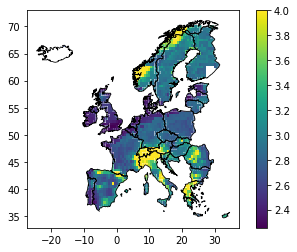

In [54]:
metric = 'LCOF_liter'
fontsize = 30

fig = plt.figure()
# fig = plt.figure(figsize=(25,25))
ax = fig.add_subplot(111)
    
data = results_gdf.copy()
df = data.loc[data.country.isin(countries)].copy()
borders = europe_borders.loc[europe_borders.country.isin(countries)].copy()
df.plot(column=metric, legend=True, vmax=4, ax=ax)
borders.boundary.plot(color='k',ax=ax, lw=0.8)

plt.savefig('/Volumes/groups/LAV/EnergySystemsGroup/Research/Aviation/SAFlogistics/paper_preparation/gfx/SAF_EUmap.png', bbox_inches='tight', dpi=300)
plt.savefig('/Volumes/groups/LAV/EnergySystemsGroup/Research/Aviation/SAFlogistics/paper_preparation/gfx/SAF_EUmap.eps', bbox_inches='tight', dpi=300)

In [44]:
row = results_gdf.loc[(results_gdf.lat==40)&(results_gdf.lon==-6.25)].copy() #
row.lon = -6.875
row

,lat,lon,turbine_type,rotor_diameter,rated_turbine_power,wind_turbines,wind_capacity_MW,PV_capacity_MW,electrolyzer_capacity_MW,CO2_capture_tonph,...,in_country,pt_in_sea,sea_node,cent_lat,cent_lon,merra_lat,merra_lon,pv_lat,pv_lon,geometry
3067,40.0,-6.875,N131/3300,131.0,3300.0,4.0,13.2,23.242534,10.341955,1.265698,...,1,0,False,40.0,-6.25,40.0,-6.25,40.0,-6.25,"POLYGON ((-6.56250 40.25000, -5.93750 40.25000..."


In [40]:
esp.loc[(esp.lat>39)&(esp.lat<41)&(esp.lon<-5)]

,lat,lon,turbine_type,rotor_diameter,rated_turbine_power,wind_turbines,wind_capacity_MW,PV_capacity_MW,electrolyzer_capacity_MW,CO2_capture_tonph,...,in_country,pt_in_sea,sea_node,cent_lat,cent_lon,merra_lat,merra_lon,pv_lat,pv_lon,geometry
2821,40.5,-6.875,GE120/2500,120.0,2500.0,6.0,15.0,16.566063,9.397608,1.158313,...,0,0,False,40.492665,-6.691174,40.5,-6.875,40.492665,-6.691174,"POLYGON ((-6.81706 40.75000, -6.56250 40.75000..."
2822,40.5,-6.250,N131/3300,131.0,3300.0,5.0,16.5,19.365578,10.751146,1.291521,...,1,0,False,40.500000,-6.250000,40.5,-6.250,40.500000,-6.250000,"POLYGON ((-6.56250 40.75000, -5.93750 40.75000..."
2823,40.5,-5.625,GE120/2500,120.0,2500.0,7.0,17.5,25.984142,12.265047,1.401734,...,1,0,False,40.500000,-5.625000,40.5,-5.625,40.500000,-5.625000,"POLYGON ((-5.93750 40.75000, -5.31250 40.75000..."
3030,39.5,-7.500,N131/3000,131.0,3000.0,4.0,12.0,20.947485,10.259924,1.100661,...,0,0,False,39.503549,-7.299444,39.5,-7.500,39.503549,-7.299444,"POLYGON ((-7.18750 39.66463, -7.18750 39.25000..."
3031,39.5,-6.875,GE120/2500,120.0,2500.0,5.0,12.5,21.067916,9.848536,1.134975,...,1,0,False,39.488597,-6.862991,39.5,-6.875,39.488597,-6.862991,"POLYGON ((-6.97939 39.75000, -6.56250 39.75000..."
3032,39.5,-6.250,N131/3300,131.0,3300.0,4.0,13.2,21.881947,10.207177,1.172155,...,1,0,False,39.500000,-6.250000,39.5,-6.250,39.500000,-6.250000,"POLYGON ((-6.56250 39.75000, -5.93750 39.75000..."
3033,39.5,-5.625,N131/3300,131.0,3300.0,5.0,16.5,18.093429,10.571416,1.206242,...,1,0,False,39.500000,-5.625000,39.5,-5.625,39.500000,-5.625000,"POLYGON ((-5.93750 39.75000, -5.31250 39.75000..."
3067,40.0,-6.250,N131/3300,131.0,3300.0,4.0,13.2,23.242534,10.341955,1.265698,...,1,0,False,40.000000,-6.250000,40.0,-6.250,40.000000,-6.250000,"POLYGON ((-6.56250 40.25000, -5.93750 40.25000..."
3068,40.0,-5.625,N131/3300,131.0,3300.0,5.0,16.5,24.400652,11.818458,1.219754,...,1,0,False,40.000000,-5.625000,40.0,-5.625,40.000000,-5.625000,"POLYGON ((-5.93750 40.25000, -5.31250 40.25000..."
3256,39.5,-7.500,N131/3000,131.0,3000.0,4.0,12.0,20.947485,10.259924,1.100661,...,0,0,False,39.503549,-7.299444,39.5,-7.500,39.503549,-7.299444,"POLYGON ((-7.18750 39.66463, -7.18750 39.25000..."


# Investigate high curtailed electricity

In [51]:
results_gdf.sort_values('curtailed_el_MWh',ascending=False).head(3)

,lat,lon,turbine_type,rotor_diameter,rated_turbine_power,wind_turbines,wind_capacity_MW,PV_capacity_MW,electrolyzer_capacity_MW,CO2_capture_tonph,...,PV_production_MWh,NPV_EUR,CAPEX_EUR,LCOF_MWh,LCOF_liter,runtime,country,PV_lat,PV_lon,geometry
50,47.5,10.625,N131/3300,131.0,3300.0,10.0,33.0,32.862530,14.276032,2.053427,...,26089.293703,1.317408e+08,8.061807e+07,804.649227,7.688870,1110.636494,Austria,47.390128,10.659047,"POLYGON ((10.93750 47.46889, 10.93750 47.25000..."
7,46.5,6.250,N131/3300,131.0,3300.0,7.0,23.1,23.527501,11.974207,1.221147,...,30478.994253,9.712394e+07,6.211337e+07,593.215669,5.668505,1008.013400,Switzerland,46.528093,6.329267,"POLYGON ((6.42015 46.75000, 6.56250 46.75000, ..."
6,46.0,10.000,GE120/2500,120.0,2500.0,9.0,22.5,148.706301,23.033372,2.207753,...,145623.739466,3.681098e+08,2.703777e+08,2248.348945,21.484223,432.779653,Switzerland,46.239057,10.098074,"POLYGON ((10.04078 46.25000, 10.15876 46.25000..."


In [62]:
country = 'Austria'
point = (47.5,10.625)
site = pop.Site(point,country)
plant = pop.Plant(site)
plant.operation = pd.read_parquet(f'../../results/02_plant_optimization/operation/{country}_{point[0]}_{point[1]}.parquet.gzip')
plant.operation.head()

,wind_production_kWh,PV_production_kWh,battery_chr_kWh,battery_dis_kWh,battery_state_kWh,H2stor_chr_kWh,H2stor_dis_kWh,H2stor_state_kWh,CO2stor_chr_kg,CO2stor_dis_kg,...,H2_el_kWh,CO2_el_kWh,H2tL_el_kWh,heat_el_kWh,battery_flow_kWh,H2_production_kWh,CO2_consumption_kg,CO2_production_kg,CO2stor_flow_kg,fuel_production_kWh
time,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:30:00,0.000000,0.0,0.0,254.831973,550.988050,9.995834e+06,1.000000e+07,69216.976394,9.999378e+06,1.000000e+07,...,0.000000,254.831973,0.0,0.0,-254.831973,0.000000,159891.75673,159269.983129,-621.7736,1221.395576
2016-01-01 01:30:00,0.000000,0.0,0.0,254.831973,275.494025,0.000000e+00,4.165566e+03,65051.410616,9.999378e+06,1.000000e+07,...,0.000000,254.831973,0.0,0.0,-254.831973,0.000000,159891.75673,159269.983129,-621.7736,1221.395576
2016-01-01 02:30:00,459.361453,0.0,0.0,0.000000,0.000000,0.000000e+00,4.042848e+03,60885.844838,9.999378e+06,1.000000e+07,...,204.529480,254.831973,0.0,0.0,0.000000,122.717688,159891.75673,159269.983129,-621.7736,1221.395576
2016-01-01 03:30:00,2076.424904,0.0,0.0,0.000000,0.000000,0.000000e+00,3.072610e+03,56842.996747,0.000000e+00,6.217736e+02,...,1821.592931,254.831973,0.0,0.0,0.000000,1092.955759,159891.75673,159269.983129,-621.7736,1221.395576
2016-01-01 04:30:00,4427.816467,0.0,0.0,0.000000,0.000000,9.998338e+06,1.000000e+07,53770.386728,0.000000e+00,6.217736e+02,...,4172.984494,254.831973,0.0,0.0,0.000000,2503.790697,159891.75673,159269.983129,-621.7736,1221.395576


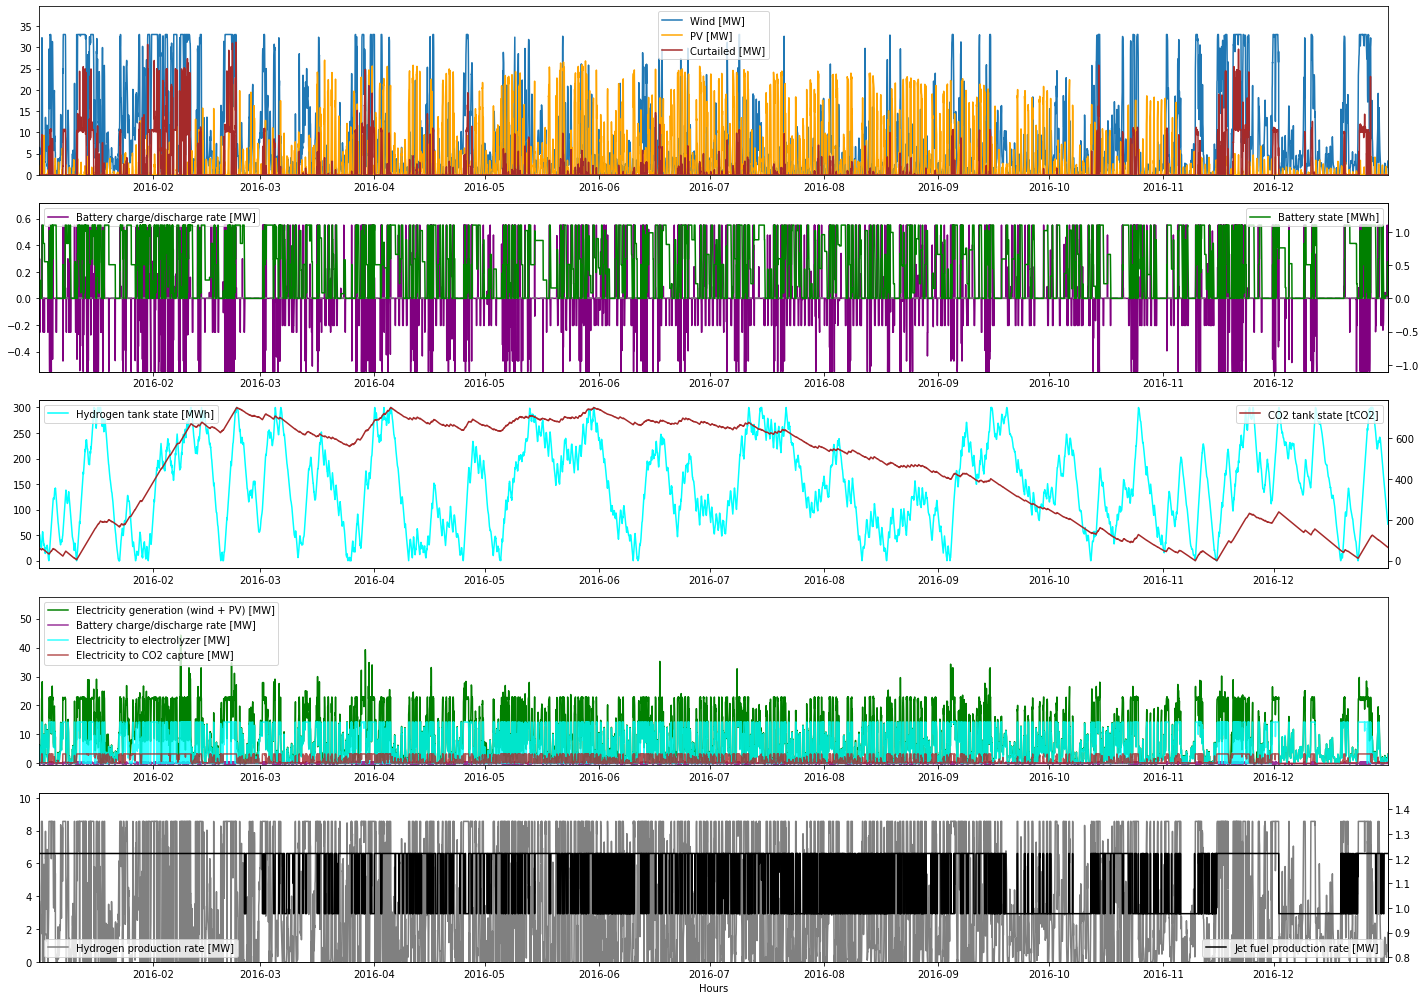

In [63]:
plot_plant_operation(plant)

AttributeError: 'DataFrame' object has no attribute 'site'

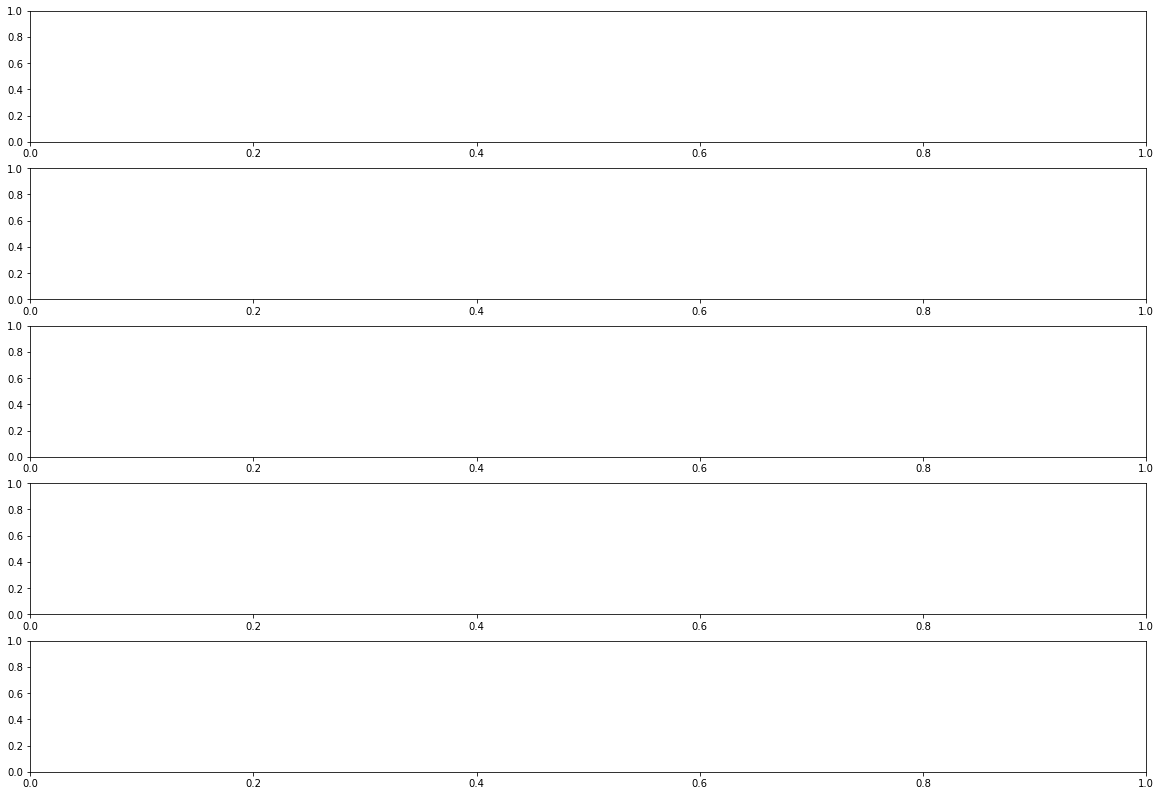